In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
cd '/content'

/content


In [2]:
import numpy as np
import torch
import sys
import torch.optim
import torch.nn as nn
import torch.nn.init as init
from torch.utils.data import Dataset, DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms
from torch.autograd import Variable
import torch.nn.functional as F
from PIL import Image
import time
import csv
import os
from os import path
import pandas as pd

batch_size = 1
n_workers = 2
cuda = torch.cuda.is_available()
print(cuda, sys.version)
device = torch.device("cuda" if cuda else "cpu")

True 3.7.10 (default, May  3 2021, 02:48:31) 
[GCC 7.5.0]


In [3]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 4315175896363251340, name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 15505193728
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 13305961756698767799
 physical_device_desc: "device: 0, name: Tesla V100-SXM2-16GB, pci bus id: 0000:00:04.0, compute capability: 7.0"]

In [ ]:
# data
!cp /content/gdrive/MyDrive/dl/project/unique-142p.zip /content
!cp /content/gdrive/MyDrive/dl/project/scene-change.csv /content
!unzip /content/unique-142p.zip

In [5]:
# Get K,  the num of rows from val data which is num of scene change
df_v = pd.read_csv('scene-change.csv')
K = len(df_v)
K

259

In [6]:
class TrainDataset(Dataset):
    def __init__(self, main_dir, transform):
        self.main_dir = main_dir
        self.transform = transform
        imgs = os.listdir(main_dir)
        self.total_imgs = []
        for i in imgs:
          if 'frame' in i and int(i[6:-4]) > 25947:
            self.total_imgs.append(i)
        

    def __len__(self):
        return len(self.total_imgs)

    def __getitem__(self, idx):
        img_loc = os.path.join(self.main_dir, self.total_imgs[idx])
        image = Image.open(img_loc).convert("RGB")
        tensor_image = self.transform(image)
        return tensor_image

class ValDataset(Dataset):
    def __init__(self, main_dir, transform):
        self.main_dir = main_dir
        self.transform = transform
        imgs = os.listdir(main_dir)
        self.total_imgs = []
        for i in imgs:
          if 'frame' in i and int(i[6:-4]) <= 25947:
            self.total_imgs.append(i) 
        self.total_imgs.sort()
        

    def __len__(self):
        return len(self.total_imgs)

    def __getitem__(self, idx):
        img_loc = os.path.join(self.main_dir, self.total_imgs[idx])
        image = Image.open(img_loc).convert("RGB")
        tensor_image = self.transform(image)
        return tensor_image

transform = transforms.Compose([
        transforms.Resize((64, 64)),
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),])


In [7]:
val_dataset = ValDataset("unique-142p", transform)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=n_workers, pin_memory=False, drop_last=True)

In [8]:
def reconstruction_loss(x, x_recon, distribution):
    batch_size = x.size(0)
    assert batch_size != 0

    if distribution == 'bernoulli':
        recon_loss = F.binary_cross_entropy_with_logits(x_recon, x, size_average=False).div(batch_size)
    elif distribution == 'gaussian':
        x_recon = F.sigmoid(x_recon)
        recon_loss = F.mse_loss(x_recon, x, size_average=False).div(batch_size)
    else:
        recon_loss = None

    return recon_loss


def kl_divergence(mu, logvar):
    print(batch_size)
    assert batch_size != 0
    if mu.data.ndimension() == 4:
        mu = mu.view(mu.size(0), mu.size(1))
    if logvar.data.ndimension() == 4:
        logvar = logvar.view(logvar.size(0), logvar.size(1))

    klds = -0.5*(1 + logvar - mu.pow(2) - logvar.exp())
    total_kld = klds.sum(1).mean(0, True)
    dimension_wise_kld = klds.mean(0)
    mean_kld = klds.mean(1).mean(0, True)

    return total_kld, dimension_wise_kld, mean_kld

In [9]:
def reparametrize(mu, logvar):
    std = logvar.div(2).exp()
    eps = Variable(std.data.new(std.size()).normal_())
    return mu + std*eps


class View(nn.Module):
    def __init__(self, size):
        super(View, self).__init__()
        self.size = size

    def forward(self, tensor):
        return tensor.view(self.size)

In [10]:
class BetaVAE_H(nn.Module):
    """Model proposed in original beta-VAE paper(Higgins et al, ICLR, 2017)."""

    def __init__(self, z_dim=10, nc=3):
        super(BetaVAE_H, self).__init__()
        self.z_dim = z_dim
        self.nc = nc
        self.encoder = nn.Sequential(
            nn.Conv2d(nc, 32, 4, 2, 1),          # B,  32, 32, 32
            nn.ReLU(True),
            nn.Conv2d(32, 32, 4, 2, 1),          # B,  32, 16, 16
            nn.ReLU(True),
            nn.Conv2d(32, 64, 4, 2, 1),          # B,  64,  8,  8
            nn.ReLU(True),
            nn.Conv2d(64, 64, 4, 2, 1),          # B,  64,  4,  4
            nn.ReLU(True),
            nn.Conv2d(64, 256, 4, 1),            # B, 256,  1,  1
            nn.ReLU(True),
            View((-1, 256*1*1)),                 # B, 256
            nn.Linear(256, z_dim*2),             # B, z_dim*2
        )
        self.decoder = nn.Sequential(
            nn.Linear(z_dim, 256),               # B, 256
            View((-1, 256, 1, 1)),               # B, 256,  1,  1
            nn.ReLU(True),
            nn.ConvTranspose2d(256, 64, 4),      # B,  64,  4,  4
            nn.ReLU(True),
            nn.ConvTranspose2d(64, 64, 4, 2, 1), # B,  64,  8,  8
            nn.ReLU(True),
            nn.ConvTranspose2d(64, 32, 4, 2, 1), # B,  32, 16, 16
            nn.ReLU(True),
            nn.ConvTranspose2d(32, 32, 4, 2, 1), # B,  32, 32, 32
            nn.ReLU(True),
            nn.ConvTranspose2d(32, nc, 4, 2, 1),  # B, nc, 64, 64
        )

        self.weight_init()

    def weight_init(self):
        for block in self._modules:
            for m in self._modules[block]:
                kaiming_init(m)

    def forward(self, x, train=True):
        distributions = self.encoder(x)
        mu = distributions[:, :self.z_dim]
        logvar = distributions[:, self.z_dim:]
        z = reparametrize(mu, logvar)
        x_recon = self.decoder(z)

        if not train:
          return x_recon, z
          
        return x_recon, mu, logvar

In [11]:
def kaiming_init(m):
    if isinstance(m, (nn.Linear, nn.Conv2d)):
        init.kaiming_normal_(m.weight)
        if m.bias is not None:
            m.bias.data.fill_(0)
    elif isinstance(m, (nn.BatchNorm1d, nn.BatchNorm2d)):
        m.weight.data.fill_(1)
        if m.bias is not None:
            m.bias.data.fill_(0)


def normal_init(m, mean, std):
    if isinstance(m, (nn.Linear, nn.Conv2d)):
        m.weight.data.normal_(mean, std)
        if m.bias.data is not None:
            m.bias.data.zero_()
    elif isinstance(m, (nn.BatchNorm2d, nn.BatchNorm1d)):
        m.weight.data.fill_(1)
        if m.bias.data is not None:
            m.bias.data.zero_()

In [13]:
model = BetaVAE_H()
new_model = BetaVAE_H(20)
print(new_model)

BetaVAE_H(
  (encoder): Sequential(
    (0): Conv2d(3, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(32, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (5): ReLU(inplace=True)
    (6): Conv2d(64, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(64, 256, kernel_size=(4, 4), stride=(1, 1))
    (9): ReLU(inplace=True)
    (10): View()
    (11): Linear(in_features=256, out_features=40, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=20, out_features=256, bias=True)
    (1): View()
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(256, 64, kernel_size=(4, 4), stride=(1, 1))
    (4): ReLU(inplace=True)
    (5): ConvTranspose2d(64, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): ConvTranspose2d(64, 32, kernel_siz

In [14]:
%cd /content/gdrive/MyDrive/dl/project/new_model/

/content/gdrive/MyDrive/dl/project/new_model


In [15]:
checkpoint = torch.load('new_model_0.25_99')
model_0_25 = BetaVAE_H()
model_0_25.load_state_dict(checkpoint['model_state_dict'])
TRL_0_25 = checkpoint['trl']
TBL_0_25 = checkpoint['tbl']
TKL_0_25 = checkpoint['tkl']
RL_0_25 = checkpoint['rl']
BL_0_25 = checkpoint['bl']
KL_0_25 = checkpoint['kl']
val_RL_0_25 = checkpoint['val_rl']
val_BL_0_25 = checkpoint['val_bl']
val_KL_0_25 = checkpoint['val_kl']

checkpoint = torch.load('new_model_0.5_99')
model_05 = BetaVAE_H()
model_05.load_state_dict(checkpoint['model_state_dict'])
TRL_05 = checkpoint['trl'] 
TBL_05 = checkpoint['tbl'] 
TKL_05 = checkpoint['tkl'] 
RL_05 = checkpoint['rl'] 
BL_05 = checkpoint['bl'] 
KL_05 = checkpoint['kl'] 
val_RL_05 = checkpoint['val_rl'] 
val_BL_05 = checkpoint['val_bl'] 
val_KL_05 = checkpoint['val_kl'] 

checkpoint = torch.load('new_model_1_99')
model_1 = BetaVAE_H()
model_1.load_state_dict(checkpoint['model_state_dict'])
TRL_1 = checkpoint['trl'] 
TBL_1 = checkpoint['tbl'] 
TKL_1 = checkpoint['tkl'] 
RL_1 = checkpoint['rl'] 
BL_1 = checkpoint['bl'] 
KL_1 = checkpoint['kl'] 
val_RL_1 = checkpoint['val_rl'] 
val_BL_1 = checkpoint['val_bl'] 
val_KL_1 = checkpoint['val_kl']

checkpoint = torch.load('new_model_2_99')
model_2 = BetaVAE_H()
model_2.load_state_dict(checkpoint['model_state_dict'])
TRL_2 = checkpoint['trl'] 
TBL_2 = checkpoint['tbl'] 
TKL_2 = checkpoint['tkl'] 
RL_2 = checkpoint['rl'] 
BL_2 = checkpoint['bl'] 
KL_2 = checkpoint['kl'] 
val_RL_2 = checkpoint['val_rl'] 
val_BL_2 = checkpoint['val_bl'] 
val_KL_2 = checkpoint['val_kl'] 

checkpoint = torch.load('new_model_4_99')
model_4 = BetaVAE_H()
model_4.load_state_dict(checkpoint['model_state_dict'])
TRL_4 = checkpoint['trl']
TBL_4 = checkpoint['tbl']
TKL_4 = checkpoint['tkl']
RL_4 = checkpoint['rl']
BL_4 = checkpoint['bl']
KL_4 = checkpoint['kl']
val_RL_4 = checkpoint['val_rl']
val_BL_4 = checkpoint['val_bl']
val_KL_4 = checkpoint['val_kl']

checkpoint = torch.load('new_model_new_z_20_4_99')
model_z = BetaVAE_H(20)
model_z.load_state_dict(checkpoint['model_state_dict'])
TRL_z = checkpoint['trl']
TBL_z = checkpoint['tbl']
TKL_z = checkpoint['tkl']
RL_z = checkpoint['rl']
BL_z = checkpoint['bl']
KL_z = checkpoint['kl']
val_RL_z = checkpoint['val_rl']
val_BL_z = checkpoint['val_bl']
val_KL_z = checkpoint['val_kl']

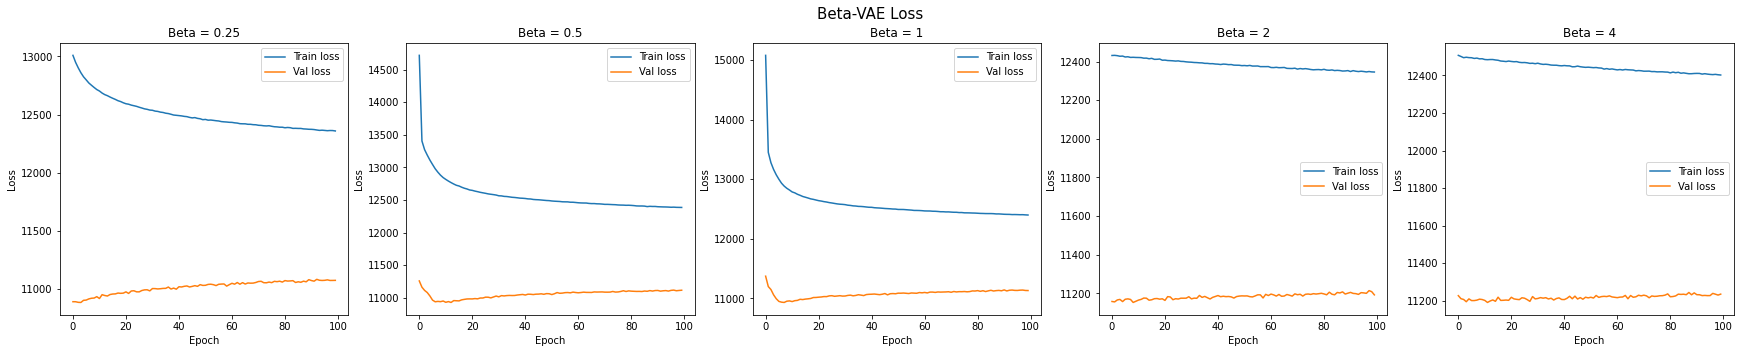

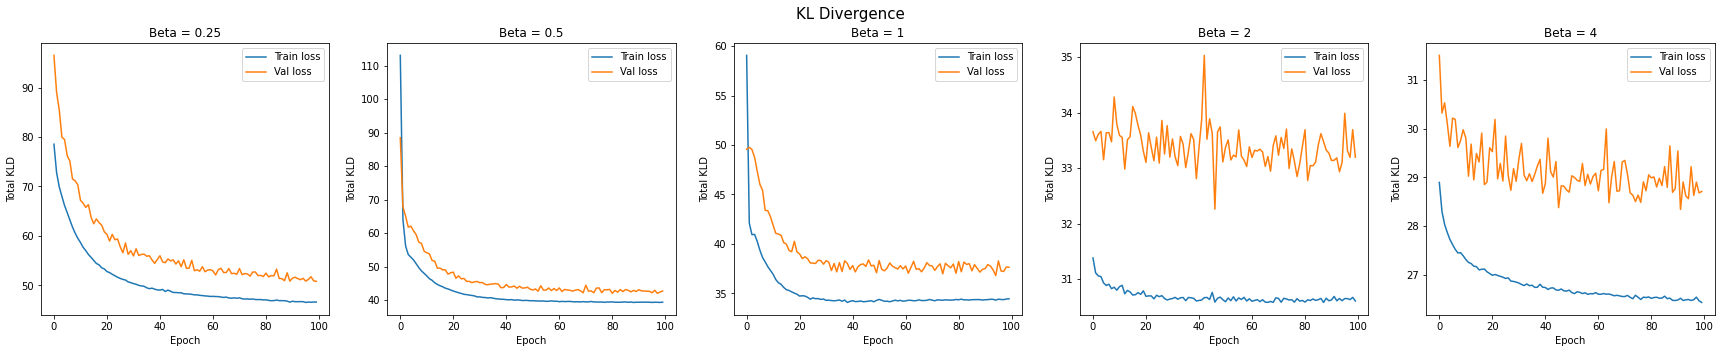

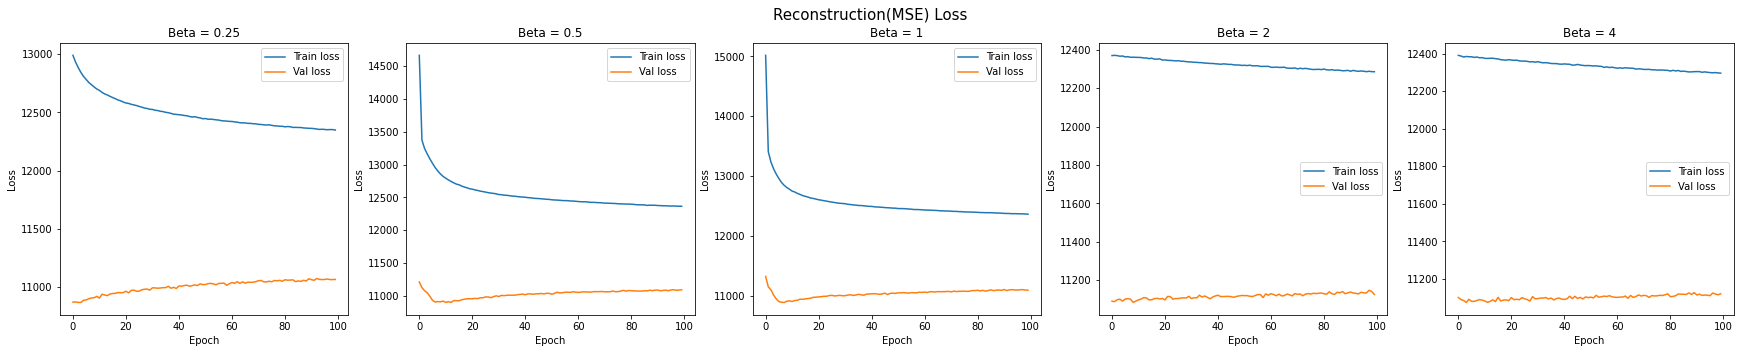

In [16]:
import matplotlib.pyplot as plt

fig1, axs1 = plt.subplots(1, 5, figsize=(30,5))
fig2, axs2 = plt.subplots(1, 5, figsize=(30,5))
fig3, axs3 = plt.subplots(1, 5, figsize=(30,5))
fig1.suptitle('Beta-VAE Loss', fontsize=15)
fig2.suptitle('KL Divergence', fontsize=15)
fig3.suptitle('Reconstruction(MSE) Loss', fontsize=15)


axs1[0].plot(BL_0_25)
axs1[0].plot(val_BL_0_25)
axs1[0].set_title('Beta = 0.25')
axs1[0].set_xlabel('Epoch', fontsize=10)
axs1[0].set_ylabel('Loss', fontsize=10)
axs1[0].legend(['Train loss', 'Val loss'])

axs1[1].plot(BL_05)
axs1[1].plot(val_BL_05)
axs1[1].set_title('Beta = 0.5')
axs1[1].set_xlabel('Epoch', fontsize=10)
axs1[1].set_ylabel('Loss', fontsize=10)
axs1[1].legend(['Train loss', 'Val loss'])

axs1[2].plot(BL_1)
axs1[2].plot(val_BL_1)
axs1[2].set_title('Beta = 1')
axs1[2].set_xlabel('Epoch', fontsize=10)
axs1[2].set_ylabel('Loss', fontsize=10)
axs1[2].legend(['Train loss', 'Val loss'])

axs1[3].plot(BL_2)
axs1[3].plot(val_BL_2)
axs1[3].set_title('Beta = 2')
axs1[3].set_xlabel('Epoch', fontsize=10)
axs1[3].set_ylabel('Loss', fontsize=10)
axs1[3].legend(['Train loss', 'Val loss'])

axs1[4].plot(BL_4)
axs1[4].plot(val_BL_4)
axs1[4].set_title('Beta = 4')
axs1[4].set_xlabel('Epoch', fontsize=10)
axs1[4].set_ylabel('Loss', fontsize=10)
axs1[4].legend(['Train loss', 'Val loss'])

# axs1[5].plot(BL_z)
# axs1[5].plot(val_BL_z)
# axs1[5].set_title('Beta = 4')
# axs1[5].set_xlabel('Epoch', fontsize=10)
# axs1[5].set_ylabel('Loss', fontsize=10)
# axs1[5].legend(['Train loss', 'Val loss'])


axs2[0].plot(KL_0_25)
axs2[0].plot(val_KL_0_25)
axs2[0].set_title('Beta = 0.25')
axs2[0].set_xlabel('Epoch', fontsize=10)
axs2[0].set_ylabel('Total KLD', fontsize=10)
axs2[0].legend(['Train loss', 'Val loss'])

axs2[1].plot(KL_05)
axs2[1].plot(val_KL_05)
axs2[1].set_title('Beta = 0.5')
axs2[1].set_xlabel('Epoch', fontsize=10)
axs2[1].set_ylabel('Total KLD', fontsize=10)
axs2[1].legend(['Train loss', 'Val loss'])

axs2[2].plot(KL_1)
axs2[2].plot(val_KL_1)
axs2[2].set_title('Beta = 1')
axs2[2].set_xlabel('Epoch', fontsize=10)
axs2[2].set_ylabel('Total KLD', fontsize=10)
axs2[2].legend(['Train loss', 'Val loss'])

axs2[3].plot(KL_2)
axs2[3].plot(val_KL_2)
axs2[3].set_title('Beta = 2')
axs2[3].set_xlabel('Epoch', fontsize=10)
axs2[3].set_ylabel('Total KLD', fontsize=10)
axs2[3].legend(['Train loss', 'Val loss'])

axs2[4].plot(KL_4)
axs2[4].plot(val_KL_4)
axs2[4].set_title('Beta = 4')
axs2[4].set_xlabel('Epoch', fontsize=10)
axs2[4].set_ylabel('Total KLD', fontsize=10)
axs2[4].legend(['Train loss', 'Val loss'])

# axs2[5].plot(KL_z)
# axs2[5].plot(val_KL_z)
# axs2[5].set_title('Beta = 4')
# axs2[5].set_xlabel('Epoch', fontsize=10)
# axs2[5].set_ylabel('Total KLD', fontsize=10)
# axs2[5].legend(['Train loss', 'Val loss'])


axs3[0].plot(RL_0_25)
axs3[0].plot(val_RL_0_25)
axs3[0].set_title('Beta = 0.25')
axs3[0].set_xlabel('Epoch', fontsize=10)
axs3[0].set_ylabel('Loss', fontsize=10)
axs3[0].legend(['Train loss', 'Val loss'])

axs3[1].plot(RL_05)
axs3[1].plot(val_RL_05)
axs3[1].set_title('Beta = 0.5')
axs3[1].set_xlabel('Epoch', fontsize=10)
axs3[1].set_ylabel('Loss', fontsize=10)
axs3[1].legend(['Train loss', 'Val loss'])

axs3[2].plot(RL_1)
axs3[2].plot(val_RL_1)
axs3[2].set_title('Beta = 1')
axs3[2].set_xlabel('Epoch', fontsize=10)
axs3[2].set_ylabel('Loss', fontsize=10)
axs3[2].legend(['Train loss', 'Val loss'])

axs3[3].plot(RL_2)
axs3[3].plot(val_RL_2)
axs3[3].set_title('Beta = 2')
axs3[3].set_xlabel('Epoch', fontsize=10)
axs3[3].set_ylabel('Loss', fontsize=10)
axs3[3].legend(['Train loss', 'Val loss'])

axs3[4].plot(RL_4)
axs3[4].plot(val_RL_4)
axs3[4].set_title('Beta = 4')
axs3[4].set_xlabel('Epoch', fontsize=10)
axs3[4].set_ylabel('Loss', fontsize=10)
axs3[4].legend(['Train loss', 'Val loss'])

# axs3[5].plot(RL_z)
# axs3[5].plot(val_RL_z)
# axs3[5].set_title('Beta = 4')
# axs3[5].set_xlabel('Epoch', fontsize=10)
# axs3[5].set_ylabel('Loss', fontsize=10)
# axs3[5].legend(['Train loss', 'Val loss'])


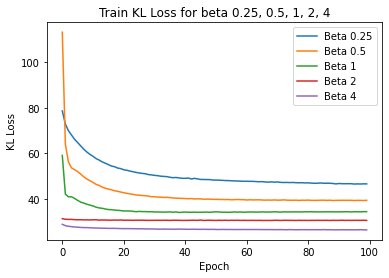

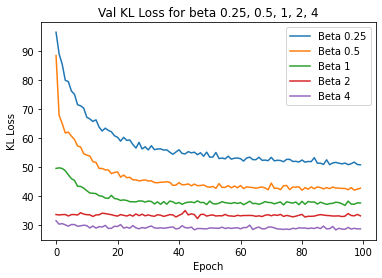

In [29]:
# Plot KLD together
plt.figure()
plt.figsize = (30,10)
plt.plot(KL_0_25)
plt.plot(KL_05)
plt.plot(KL_1)
plt.plot(KL_2)
plt.plot(KL_4)
plt.title('Train KL Loss for beta 0.25, 0.5, 1, 2, 4')
plt.xlabel('Epoch')
plt.ylabel('KL Loss')
plt.legend(['Beta 0.25', 'Beta 0.5','Beta 1','Beta 2','Beta 4'])


plt.figure()
plt.figsize = (30,10)
plt.plot(val_KL_0_25)
plt.plot(val_KL_05)
plt.plot(val_KL_1)
plt.plot(val_KL_2)
plt.plot(val_KL_4)
plt.title('Val KL Loss for beta 0.25, 0.5, 1, 2, 4')
plt.xlabel('Epoch')
plt.ylabel('KL Loss')
plt.legend(['Beta 0.25', 'Beta 0.5','Beta 1','Beta 2','Beta 4'])


In [30]:
def KL_Div(mu0, mu1, var0, var1):
    return (0.5 * (var0 / var1) + (mu1 - mu0) * (1 / var1) * (mu1 - mu0) - 1 + np.log(var1 / var0))

def KL_Div_Loss(mu0_vector, mu1_vector, var0_vector, var1_vector):
    total_KLD = 0

    for (mu0, mu1, var0, var1) in zip(mu0_vector, mu1_vector, var0_vector, var1_vector):
        total_KLD += KL_Div(mu0, mu1, var0, var1)

    return total_KLD

In [31]:
def get_mean_var(model, dataloader):
    model.eval()
    mean = None
    var = None
    for i, x in enumerate(dataloader):
        x = x.cuda()
        x_recon, mu, log_var = model(x)
        if mean is None:
            mean = mu
            var = log_var.exp()
        else:
            mean = torch.vstack((mean, mu))
            var = torch.vstack((var, log_var.exp()))
    return mean, var

In [ ]:
%cd /content

/content


In [ ]:
def find_top_kloss(m, v):
    consec_kloss = []
    for i in range(m.shape[0]-1):
        div = KL_Div_Loss(m[i], m[i+1], v[i], v[i+1])
        consec_kloss.append(div)

    consec_kloss = np.array(consec_kloss)
    arg_sorted_kloss = np.argsort(consec_kloss)
    top_k = arg_sorted_kloss[-K:]
    res = []
    for i in range(14196):
        if i in top_k:
            res.append(1)
        else:
            res.append(0)
    return res

In [ ]:
top_kloss =find_top_kloss(Z_0_25_mean, Z_0_25_var)
print(top_kloss[0])

3424


In [ ]:
def get_val_scene(df_v):
    val_scene = []
    for i in df_v.index:
        val_scene.append((df_v['frame1'][i].strip(), df_v['frame2'][i].strip()))
    return val_scene

In [ ]:
def get_val_index(main_dir, val_scene):
    main_dir = main_dir
    imgs = os.listdir(main_dir)
    val_imgs = []
    for i in imgs:
        if 'frame' in i and int(i[6:-4]) <= 25947:
            val_imgs.append(i) 
    val_imgs.sort()

    val_index = []
    for i in val_imgs:
        found = False
        for j, k in val_scene:
            if i == j:
                found = True
        val_index.append(1) if found else val_index.append(0)
    return val_index  

In [ ]:
val_scene = get_val_scene(df_v)
print(val_scene[0])
val_index = get_val_index('unique-142p', val_scene)

('frame_001278.png', 'frame_001279.png')


In [ ]:
def calc_accuracy(val_index, top_kloss):
    matrix = confusion_matrix(val_index, top_kloss)
    return matrix[1,1]/matrix[-1].sum()

In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
models = [model_0_25.cuda(), model_05.cuda(), model_1.cuda(), model_2.cuda(), model_4.cuda(), model_z.cuda()]
all_accuracy, all_precision, all_recall, all_fscore, all_topk = [], [], [], [], []
for model in models:
    Z_mean, Z_var = get_mean_var(model, val_loader)
    Z_mean = Z_mean.cpu().detach()
    Z_var = Z_var.cpu().detach()
    top_kloss = find_top_kloss(Z_mean, Z_var)
    precision = precision_score(val_index, top_kloss)
    recall = recall_score(val_index, top_kloss)
    fscore = f1_score(val_index, top_kloss)
    accuracy = accuracy_score(val_index, top_kloss)
    top_k_acc = calc_accuracy(val_index, top_kloss)
    print('top k  acc: {}'.format(top_k_acc))
    print('accuracy: {}'.format(accuracy))
    print('precision: {}'.format(precision))
    print('recall: {}'.format(recall))
    print('f1_score: {}'.format(fscore))
    all_accuracy.append(accuracy)
    all_precision.append(precision)
    all_recall.append(recall)
    all_fscore.append(fscore)
    all_topk.append(top_k_acc)


top k  acc: 0.5291828793774319
accuracy: 0.9828120597351366
precision: 0.525096525096525
recall: 0.5291828793774319
f1_score: 0.5271317829457364
top k  acc: 0.6147859922178989
accuracy: 0.9859115243730628
precision: 0.61003861003861
recall: 0.6147859922178989
f1_score: 0.6124031007751938
top k  acc: 0.6264591439688716
accuracy: 0.9863341786418709
precision: 0.6216216216216216
recall: 0.6264591439688716
f1_score: 0.6240310077519381
top k  acc: 0.6498054474708171
accuracy: 0.9871794871794872
precision: 0.6447876447876448
recall: 0.6498054474708171
f1_score: 0.6472868217054263
top k  acc: 0.6575875486381323
accuracy: 0.9874612566920259
precision: 0.6525096525096525
recall: 0.6575875486381323
f1_score: 0.6550387596899224
top k  acc: 0.6614785992217899
accuracy: 0.9876021414482953
precision: 0.6563706563706564
recall: 0.6614785992217899
f1_score: 0.6589147286821706


In [ ]:
data = {'Beta': [0.25, 0.5, 1, 2 , 4], 
        'MSE': [RL_0_25[99], RL_05[99], RL_1[99], RL_2[99], RL_4[99]], 
        'KLD': [KL_0_25[99], KL_05[99], KL_1[99], KL_2[99], KL_4[99]], 
        'Total Loss': [BL_0_25[99], BL_05[99], BL_1[99], BL_2[99], BL_4[99]],
        'Top K Accuracy': all_topk,
        'Accuracy': all_accuracy,
        'F1': all_fscore,
        'Recall': all_recall,
        'Precision': all_precision
        } 
result = pd.DataFrame(data=data)
result

,Beta,MSE,KLD,Total Loss,Top K Accuracy,Accuracy,F1,Recall,Precision
0,0.25,12348.178715,46.610867,12359.831446,0.529183,0.982812,0.527132,0.529183,0.525097
1,0.50,12365.663467,39.409636,12385.368292,0.614786,0.985912,0.612403,0.614786,0.610039
2,1.00,12364.322876,34.454013,12398.776876,0.626459,0.986334,0.624031,0.626459,0.621622
3,2.00,12285.029984,30.603758,12346.237502,0.649805,0.987179,0.647287,0.649805,0.644788
4,4.00,12296.241439,26.438303,12401.994646,0.657588,0.987461,0.655039,0.657588,0.652510
